<a href="https://colab.research.google.com/github/cam2149/MachineLearningIII/blob/main/fundamentos_de_anal%C3%ADtica_ejercicio1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


**Integrantes**


* Andrés Felipe Borrero
* Yesid Castelblanco Caro
* Nicolás Colmenares
* Carlos Alberto Martinez Ramirez

En este notebook se realizará un análisis de pronóstico de la tasa de ocupación en 13 ciudades principales, utilizando datos mensuales.  Se inicia con la carga y visualización de los datos, seguida de una descomposición de la serie temporal en sus componentes (tendencia, estacionalidad y residuos) para comprender mejor los patrones.

Posteriormente, se evalúan diferentes modelos de suavización exponencial: promedio móvil, suavización exponencial simple, suavización exponencial lineal (Holt) y suavización exponencial lineal de Winters (Holt-Winters, tanto aditiva como multiplicativa). Para cada modelo se calcula el RMSE (Root Mean Squared Error) utilizando una porción de los datos como conjunto de prueba, permitiendo comparar la precisión de cada método.

Finalmente, se comparan los modelos en función de sus RMSE y los parámetros de suavización (alpha, beta y gamma). Se identifica el mejor modelo según el RMSE más bajo y se presentan los resultados de los diferentes modelos a través de gráficos y tablas, incluyendo las proyecciones a 6 meses para el mejor modelo.  
Se resalta que las limitaciones de los pronósticos radican en la precisión de los datos históricos y la asunción de que los patrones pasados se mantendrán en el futuro.  
El notebook concluye presentando el mejor modelo según diferentes criterios y con sus parámetros estimados.


Empleando la información del número de ocupados en miles de personas (Ocupados) para las 13 principales ciudades, encuentre el mejor pronóstico para los próximos 6 meses. Escriba un breve informe de máximo una página de texto que explique cómo llega a sus proyeccciones y presente las proyecciones. Aclare en el texto cuáles serían las limitaciones de sus pronósticos.

In [227]:
#@title 1. Carga de paquetes
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from warnings import filterwarnings
filterwarnings('ignore')
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from sklearn.metrics import mean_squared_error


In [228]:
#@title 2. Carga de datos
# Load the data
data = pd.read_excel("https://raw.githubusercontent.com/cam2149/MachineLearningIII/refs/heads/main/datosEmpleo.xlsx",index_col='mes',parse_dates=True)
# Select the 'Ocupados' column
ds_ocupados = data[["Ocupados"]]

(220, 1)


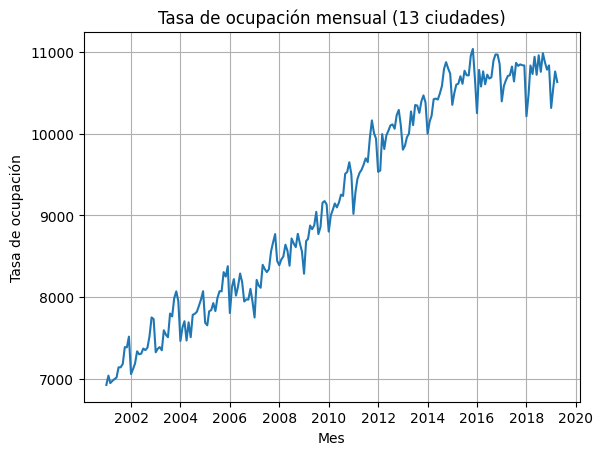

In [229]:
# imprimiendo el tamano del dataframe
print(ds_ocupados.shape)

# Graficando los datos
plt.title("Tasa de ocupación mensual (13 ciudades)")
plt.xlabel("Mes")
plt.ylabel("Tasa de ocupación")
plt.plot(ds_ocupados)
plt.grid()
plt.show()

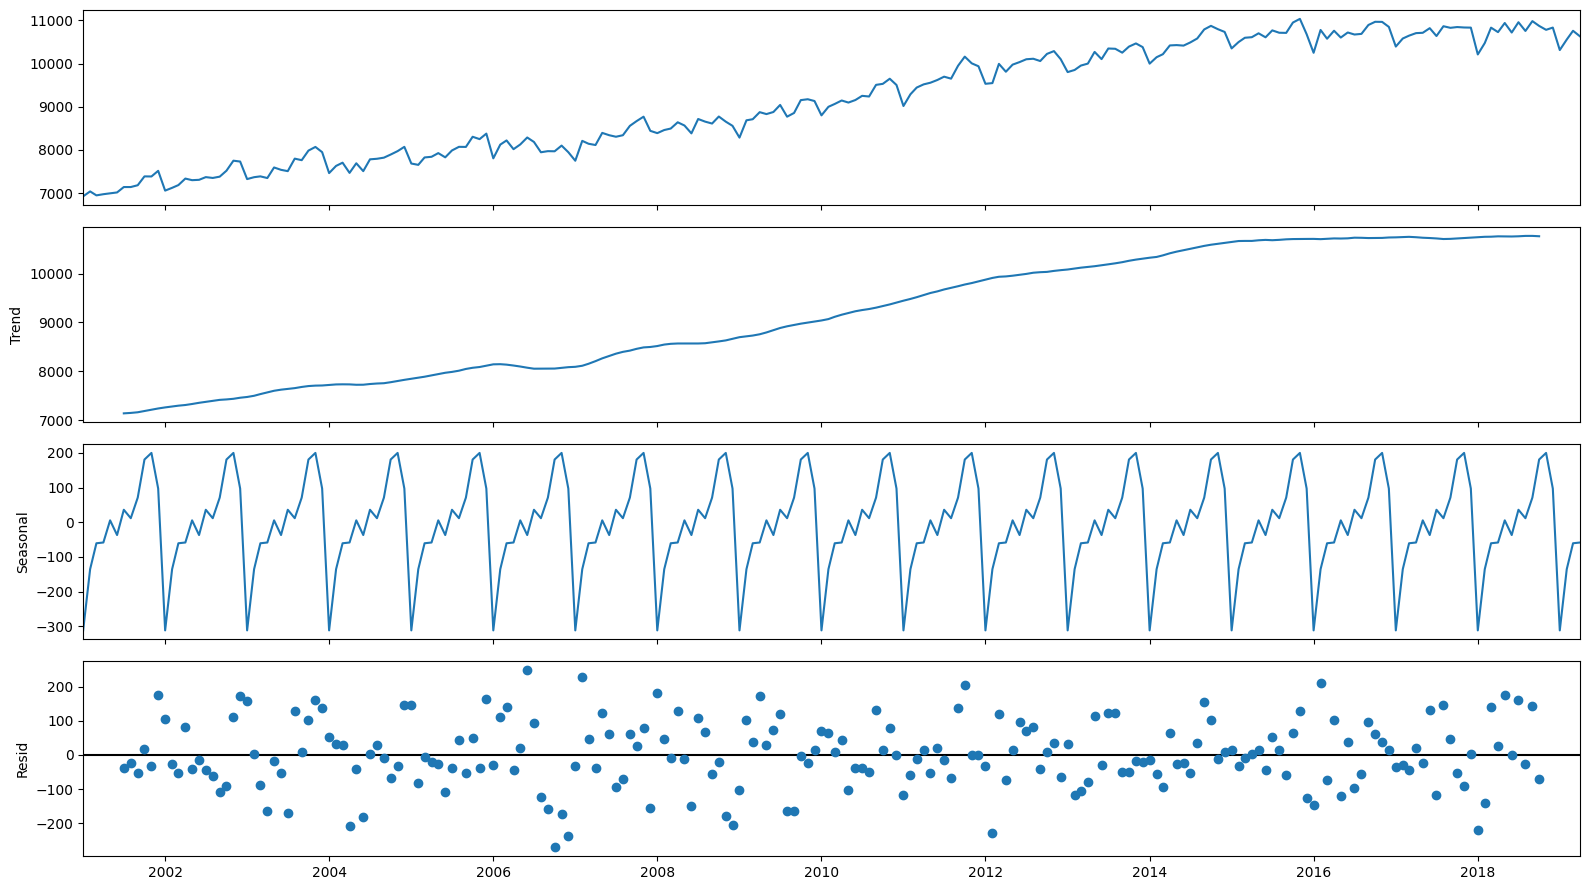

In [230]:
#Toma la serie temporal (ds_ocupados), la descompone en sus componentes de tendencia, estacionalidad y residuo utilizando un modelo aditivo, y luego visualiza estos componentes en un gráfico. Esto ayuda a comprender los patrones subyacentes y el comportamiento de los datos de la serie temporal.

#@title 3. Encontrando los componentes de una serie de tiempo
td_componentes = seasonal_decompose(ds_ocupados,model="additive")
fig = td_componentes.plot()
fig.set_size_inches((16, 9))
fig.tight_layout()
plt.show()

In [231]:
td_componentes.seasonal

,seasonal
mes,
2001-01-01,-311.454885
2001-02-01,-135.216366
2001-03-01,-60.470657
2001-04-01,-58.270721
2001-05-01,5.551095
...,...
2018-12-01,97.140345
2019-01-01,-311.454885
2019-02-01,-135.216366


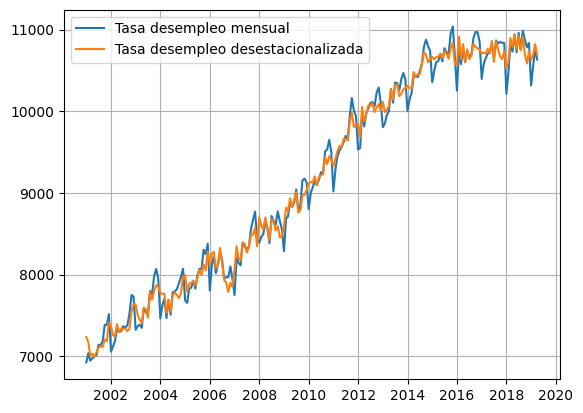

In [232]:
#td_desestacionalizada: Esta variable almacenará los datos de series temporales desestacionalizadas.
#data["Ocupados"]: Accede a la columna 'Ocupados' del data DataFrame, que representa los datos de empleo originales.
#td_componentes.seasonal: Accede al componente estacional extraído de la descomposición de series temporales realizada anteriormente y almacenado en td_componentes.
#La resta (-) elimina el componente estacional de los datos originales, lo que da como resultado datos desestacionalizados.

td_desestacionalizada = data["Ocupados"]-td_componentes.seasonal

plt.plot(data[["Ocupados"]],label="Tasa desempleo mensual")
plt.plot(td_desestacionalizada,label="Tasa desempleo desestacionalizada")
plt.legend()
plt.grid()
plt.show()

## **4. Pronosticando metodos de suavización**

Antes de continuar es importante guardar una parte de la muestra para evaluar el comportamiento de los modelos por fuera de muestra (out-of-sample). Guardemos un año de datos.

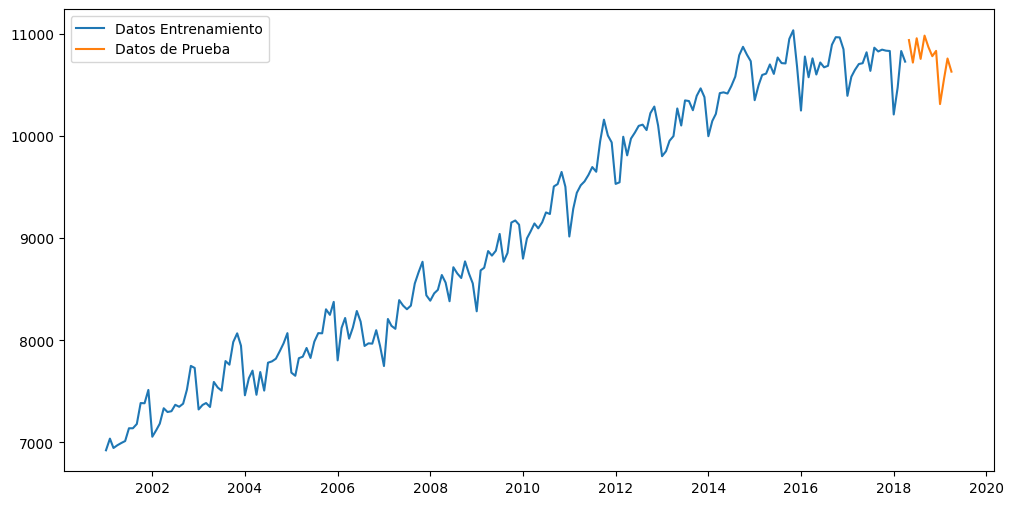

In [233]:
#Esta parte se prepara los datos para entrenar y probar un modelo de pronóstico.
#train_len = 208: define la longitud del conjunto de datos de entrenamiento. Está establecido en 208, lo que podría representar una cierta cantidad de meses o puntos de datos.

train_len = 208
train_td = data[["Ocupados"]][:train_len]
test_td = data[["Ocupados"]][train_len:]

fig = plt.figure(figsize=(12, 6))
plt.plot(train_td,label="Datos Entrenamiento")
plt.plot(test_td,label="Datos de Prueba")
plt.legend()
plt.show()


In [234]:
train_td.describe().T

,count,mean,std,min,25%,50%,75%,max
Ocupados,208.0,9052.532716,1266.050223,6923.604,7946.3435,8876.496,10303.5155,11037.199


In [235]:
test_td.describe().T

,count,mean,std,min,25%,50%,75%,max
Ocupados,12.0,10760.11175,190.62489,10314.438,10698.7165,10772.0375,10891.077,10984.928


In [236]:
train_td

,Ocupados
mes,
2001-01-01,6923.604
2001-02-01,7037.746
2001-03-01,6945.973
2001-04-01,6973.079
2001-05-01,6994.462
...,...
2017-12-01,10834.330
2018-01-01,10212.612
2018-02-01,10476.311


In [237]:
test_td

,Ocupados
mes,
2018-05-01,10941.294
2018-06-01,10720.946
2018-07-01,10959.197
2018-08-01,10756.782
2018-09-01,10984.928
2018-10-01,10874.338
2018-11-01,10783.299
2018-12-01,10835.398
2019-01-01,10314.438


### **4.1 Promedio movil**

In [238]:
#Calculando la media móvil de los datos en train_td, que probablemente representa una serie temporal de datos de empleo. Está calculando medias móviles con diferentes tamaños de ventana (2, 3, 4 y 5).

#rolling(window, min_periods): Esta es una función que se aplica a una Serie de pandas (como train_td). Crea una vista de ventana móvil de los datos.
## Considerando el dato actual

#window: Este argumento especifica el tamaño de la ventana móvil. Por ejemplo, window=2 significa que estamos considerando 2 puntos de datos a la vez para calcular la media.
#min_periods: Esto determina el número mínimo de observaciones requeridas en una ventana para tener un valor. min_periods=2 significa que necesitamos al menos 2 puntos de datos para calcular una media; de lo contrario, el resultado es NaN (No es un número).

ma_2= train_td.rolling(2,min_periods=2).mean()
ma_3= train_td.rolling(3,min_periods=2).mean()
ma_4= train_td.rolling(4,min_periods=2).mean()
ma_5= train_td.rolling(5,min_periods=2).mean()

In [239]:
 #Calculando las medias móviles en los datos de entrenamiento (train_td), pero excluyendo el dato actual en el cálculo. Esto se logra utilizando el método shift().

 #train_td.shift(): Esta línea desplaza los datos en el DataFrame train_td una posición hacia abajo. Esencialmente, mueve cada dato una fila hacia abajo, creando un retraso. La primera fila se convertirá en NaN (No es un número) porque no hay un valor previo para desplazar.

## Sin considerar el dato actual
ma_2= train_td.shift().rolling(2,min_periods=2).mean()
ma_3= train_td.shift().rolling(3,min_periods=2).mean()
ma_4= train_td.shift().rolling(4,min_periods=2).mean()
ma_5= train_td.shift().rolling(5,min_periods=2).mean()

In [240]:
def fore_ma(datos,w,h):
  data=datos.copy()
  for x in range(1,h+1):
    ind = data.index[-1]
    value = ind + pd.DateOffset(months=1)
    data.loc[value]= data[-w:].mean()
  return data[-h:]

In [241]:
ma_2_f= fore_ma(train_td,2,12)
ma_3_f= fore_ma(train_td,3,12)
ma_4_f= fore_ma(train_td,4,12)
ma_5_f= fore_ma(train_td,5,12)

In [242]:
rmse_ma_2 = np.sqrt(mean_squared_error(test_td,ma_2_f ))
rmse_ma_3 = np.sqrt(mean_squared_error(test_td,ma_3_f ))
rmse_ma_4 = np.sqrt(mean_squared_error(test_td,ma_4_f ))
rmse_ma_5 = np.sqrt(mean_squared_error(test_td,ma_5_f ))

In [243]:
print( rmse_ma_2, rmse_ma_3 ,rmse_ma_4 ,rmse_ma_5)

180.61405651284463 190.8075001193029 218.76010738130725 221.86244433696749


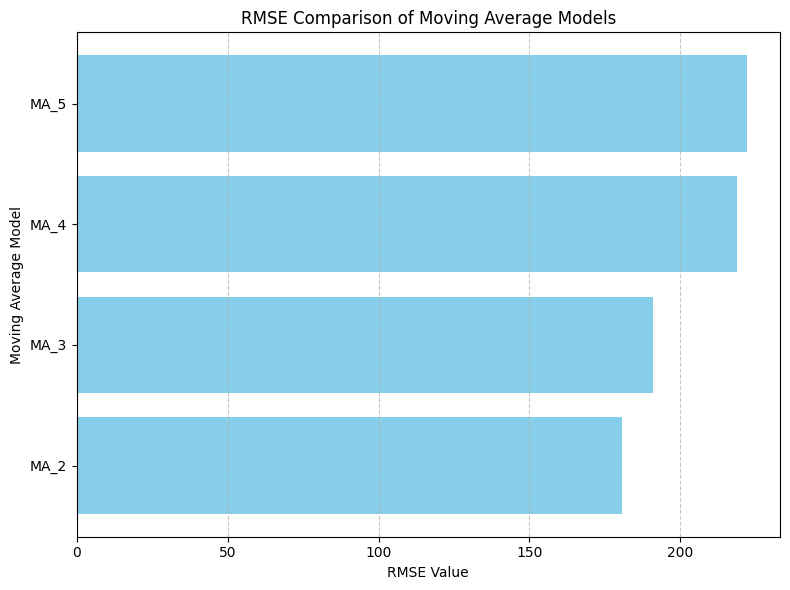

In [244]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# Data (replace with your actual rmse values)
rmse_data = {
    'RMSE': [rmse_ma_2, rmse_ma_3, rmse_ma_4, rmse_ma_5],
    'Model': ['MA_2', 'MA_3', 'MA_4', 'MA_5']
}
rmse_df = pd.DataFrame(rmse_data)

# Horizontal bar plot
plt.figure(figsize=(8, 6))
plt.barh(rmse_df['Model'], rmse_df['RMSE'], color='skyblue')
plt.xlabel('RMSE Value')
plt.ylabel('Moving Average Model')
plt.title('RMSE Comparison of Moving Average Models')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

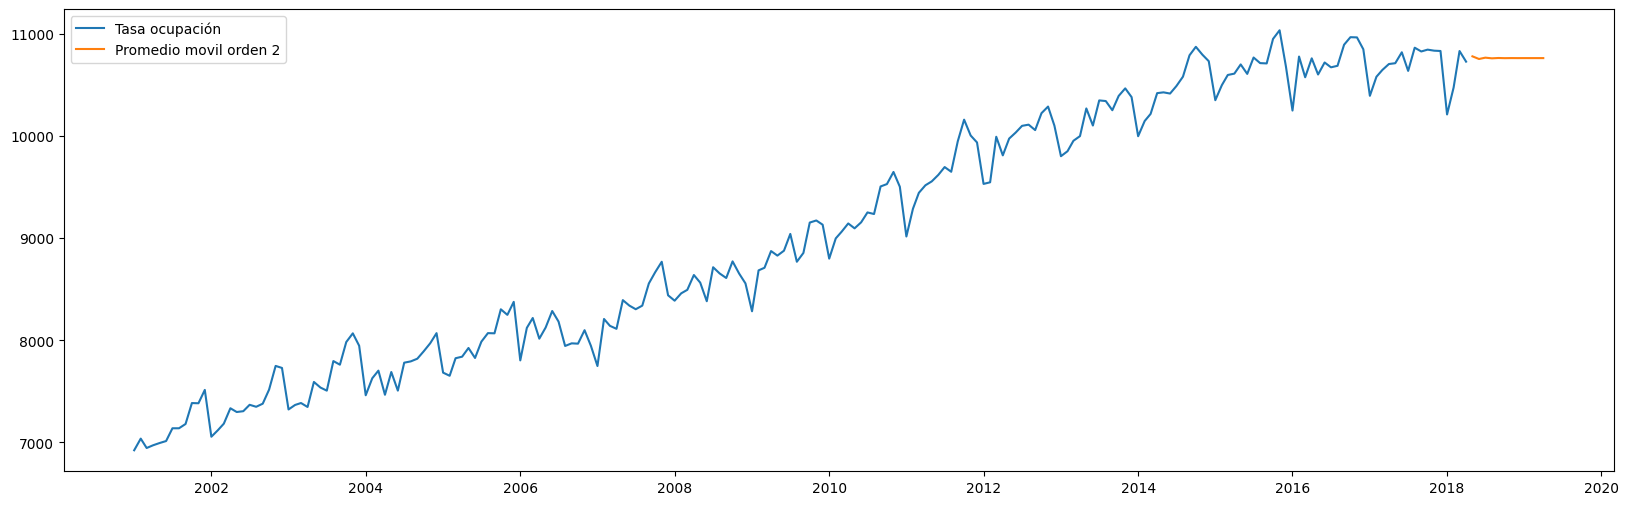

In [245]:
fig = plt.figure(figsize=(20, 6))
plt.plot(train_td,label="Tasa ocupación")
plt.plot(ma_2_f,label="Promedio movil orden 2")
plt.legend(loc='upper left')
plt.show()

### **4.2 Suavizacion Exponencial Simple**


In [246]:
# Build model.
ets_model = ETSModel(endog=train_td["Ocupados"],error="add")#,trend="add",seasonal="mul" )
ets_result = ets_model.fit()

point_forecast=ets_result.forecast(12)

ci = ets_result.get_prediction(start = point_forecast.index[0],
                                end = point_forecast.index[-1])

conf_forecast = ci.pred_int(alpha=0.05)#.iloc[:,0]
limits = ci.predicted_mean


preds = pd.concat([limits, conf_forecast], axis = 1)
preds.columns = ['Point_forecast', 'lower_95', 'upper_95']
(preds)

,Point_forecast,lower_95,upper_95
2018-05-01,10720.369929,10363.684215,11077.055642
2018-06-01,10720.369929,10295.289386,11145.450471
2018-07-01,10720.369929,10236.466801,11204.273056
2018-08-01,10720.369929,10184.057514,11256.682343
2018-09-01,10720.369929,10136.332451,11304.407406
2018-10-01,10720.369929,10092.223016,11348.516842
2018-11-01,10720.369929,10051.014034,11389.725823
2018-12-01,10720.369929,10012.198987,11428.540870
2019-01-01,10720.369929,9975.403586,11465.336271
2019-02-01,10720.369929,9940.341967,11500.397890


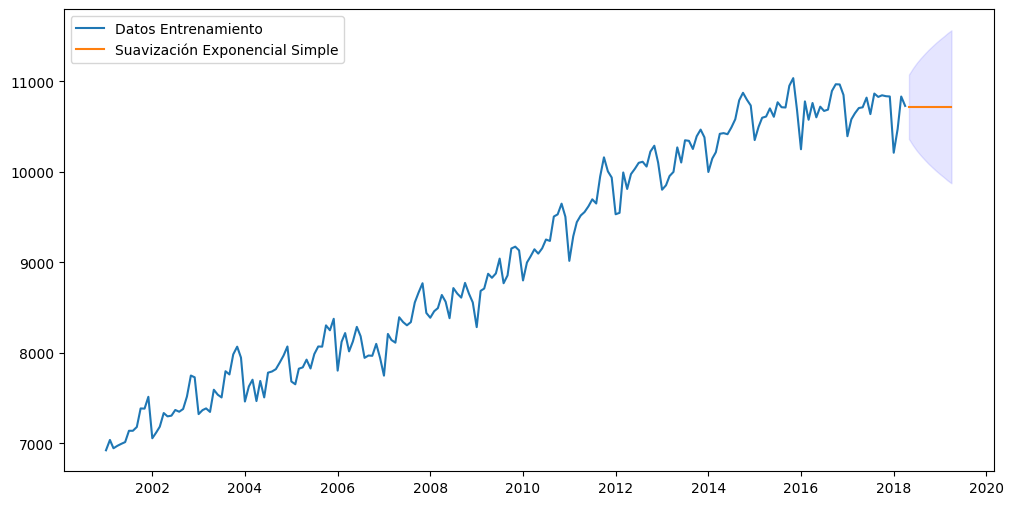

In [247]:
fig = plt.figure(figsize=(12, 6))
plt.plot(train_td,label="Datos Entrenamiento")
plt.plot(preds['Point_forecast'],label="Suavización Exponencial Simple")
plt.fill_between(preds.index ,preds['lower_95'], preds['upper_95'], color='blue', alpha=0.1)
plt.legend(loc='upper left')
plt.show()

In [248]:
ses_rmse = np.sqrt(mean_squared_error(test_td,point_forecast ))
ses_alpha = ets_result.alpha
print(ses_rmse)
print(ses_alpha)

186.78626001062813
0.64828262016549


In [249]:
print(f"En esta caso el α estimado es {ses_alpha} .Y el RMSE en la muestra de evaluación es {ses_rmse}")

En esta caso el α estimado es 0.64828262016549 .Y el RMSE en la muestra de evaluación es 186.78626001062813


### **4.3 Suavizacion Exponencial Lineal (Holt)**

In [250]:
# Build model.
ets_model = ETSModel(endog=train_td["Ocupados"],error="mul",trend="mul")#,seasonal="mul" )
ets_result = ets_model.fit()

point_forecast=ets_result.forecast(12)

ci = ets_result.get_prediction(start = point_forecast.index[0],
                                end = point_forecast.index[-1])

conf_forecast = ci.pred_int(alpha=0.05)#.iloc[:,0]
limits = ci.predicted_mean


preds_holt = pd.concat([limits, conf_forecast], axis = 1)
preds_holt.columns = ['Point_forecast', 'lower_95', 'upper_95']
(preds_holt)

,Point_forecast,lower_95,upper_95
2018-05-01,10749.538883,10359.226957,11169.579680
2018-06-01,10773.218975,10321.032050,11259.820290
2018-07-01,10796.951232,10289.996435,11309.385047
2018-08-01,10820.735768,10230.149897,11392.197878
2018-09-01,10844.572699,10197.519312,11508.173783
2018-10-01,10868.462141,10231.988392,11483.775573
2018-11-01,10892.404208,10181.498796,11583.837099
2018-12-01,10916.399017,10215.393557,11638.634676
2019-01-01,10940.446684,10141.785890,11710.858048
2019-02-01,10964.547326,10132.057211,11783.898672


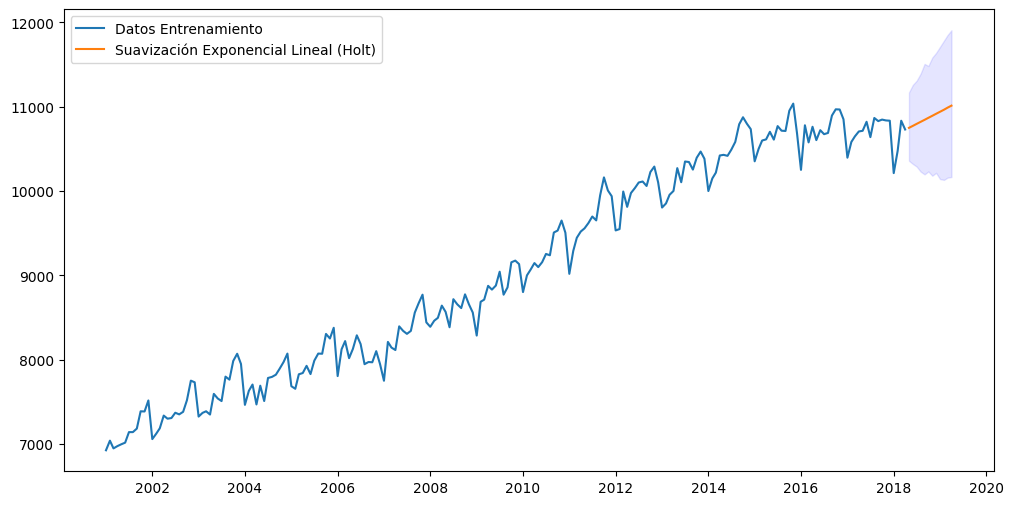

In [251]:
fig = plt.figure(figsize=(12, 6))
plt.plot(train_td,label="Datos Entrenamiento")
plt.plot(preds_holt['Point_forecast'],label="Suavización Exponencial Lineal (Holt)")
plt.fill_between(preds_holt.index ,preds_holt['lower_95'], preds_holt['upper_95'], color='blue', alpha=0.1)
plt.legend(loc='upper left')
plt.show()

In [252]:
rmse_holt = np.sqrt(mean_squared_error(test_td,preds_holt['Point_forecast']))
print(rmse_holt)

268.07492885990695


In [253]:
sel_holt_alpha = ets_result.alpha
sel_holt_beta = ets_result.beta
print(sel_holt_alpha,sel_holt_beta)
print(f"En esta caso el α estimado es {sel_holt_alpha} y el β estimado es {sel_holt_beta} . Y el RMSE en la muestra de evaluación es {rmse_holt}.")

0.5619350383434504 5.619350383434504e-05
En esta caso el α estimado es 0.5619350383434504 y el β estimado es 5.619350383434504e-05 . Y el RMSE en la muestra de evaluación es 268.07492885990695.


### **4.3 Suavizacion Exponencial Lineal de Winters (Holt-Winters)**

####"Suavización Exponencial Lineal (Holt-Winters) Aditivo"

In [254]:
ets_model = ETSModel(endog=train_td["Ocupados"],error="add",trend="add",seasonal="add" )
ets_result = ets_model.fit()

point_forecast=ets_result.forecast(12)

ci = ets_result.get_prediction(start = point_forecast.index[0],
                                end = point_forecast.index[-1])

conf_forecast = ci.pred_int(alpha=0.05)#.iloc[:,0]
limits = ci.predicted_mean


preds_hw_add = pd.concat([limits, conf_forecast], axis = 1)
preds_hw_add.columns = ['Point_forecast', 'lower_95', 'upper_95']
(preds_hw_add)

,Point_forecast,lower_95,upper_95
2018-05-01,10798.400903,10576.753335,11020.048472
2018-06-01,10786.645311,10536.711164,11036.579458
2018-07-01,10864.222813,10588.888146,11139.557480
2018-08-01,10870.075531,10571.488948,11168.662115
2018-09-01,10934.690701,10614.532325,11254.849076
2018-10-01,11077.997076,10737.627438,11418.366715
2018-11-01,11113.088752,10753.638804,11472.538701
2018-12-01,11027.773060,10650.202260,11405.343861
2019-01-01,10640.970865,10246.106556,11035.835174
2019-02-01,10832.497382,10421.062569,11243.932196


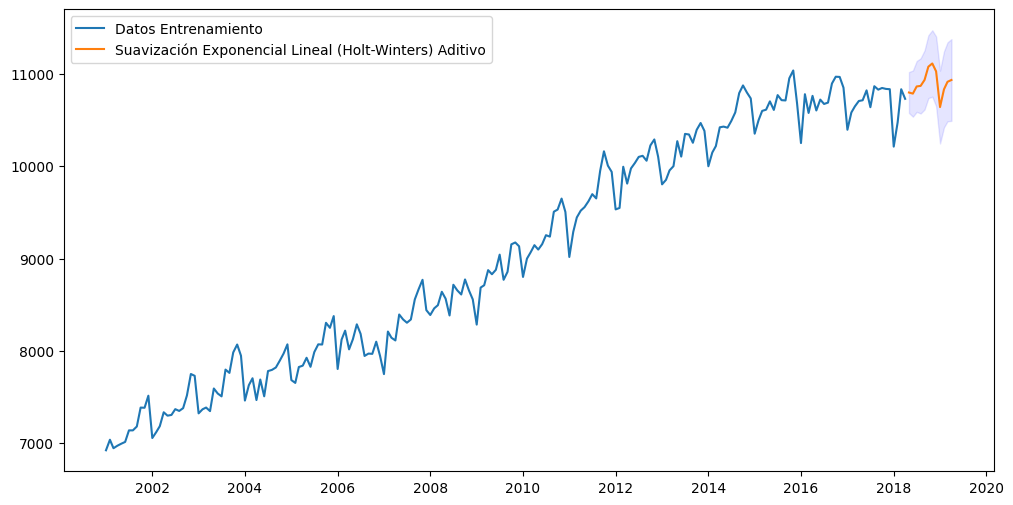

In [255]:
fig = plt.figure(figsize=(12, 6))
plt.plot(train_td,label="Datos Entrenamiento")
plt.plot(preds_hw_add['Point_forecast'],label="Suavización Exponencial Lineal (Holt-Winters) Aditivo")
plt.fill_between(preds_hw_add.index ,preds_hw_add['lower_95'], preds_hw_add['upper_95'], color='blue', alpha=0.1)
plt.legend(loc='upper left')
plt.show()

In [256]:
sel_winter_alpha = ets_result.alpha,
sel_winter_beta = ets_result.beta,
sel_winter_gamma  = ets_result.gamma
print(sel_winter_alpha,sel_winter_beta,sel_winter_gamma)

(0.5210294726964335,) (5.210294726964335e-05,) 4.7897052730356654e-05


In [257]:
rmse_hw_add = np.sqrt(mean_squared_error(test_td,preds_hw_add['Point_forecast']))
print(rmse_hw_add)

210.80972716286084


In [258]:
print(f"En esta caso el α estimado es {sel_winter_alpha}, el β estimado es {sel_winter_beta}, el γ estimado es {sel_winter_gamma}. Y el RMSE en la muestra de evaluación es {rmse_hw_add}.")

En esta caso el α estimado es (0.5210294726964335,), el β estimado es (5.210294726964335e-05,), el γ estimado es 4.7897052730356654e-05. Y el RMSE en la muestra de evaluación es 210.80972716286084.


####"Suavización Exponencial Lineal (Holt-Winters) Multiplicativo"

In [259]:

ets_model = ETSModel(endog=train_td["Ocupados"],error="add",trend=None,seasonal="mul" , )
ets_result = ets_model.fit()

point_forecast=ets_result.forecast(12)

ci = ets_result.get_prediction(start = point_forecast.index[0],
                                end = point_forecast.index[-1])

conf_forecast = ci.pred_int(alpha=0.05)#.iloc[:,0]
limits = ci.predicted_mean


preds_hw_mul = pd.concat([limits, conf_forecast], axis = 1)
preds_hw_mul.columns = ['Point_forecast', 'lower_95', 'upper_95']
(preds_hw_mul)

,Point_forecast,lower_95,upper_95
2018-05-01,10787.445073,10560.290717,11021.791685
2018-06-01,10757.065081,10498.190956,11021.512586
2018-07-01,10832.085926,10529.219045,11127.999603
2018-08-01,10816.529688,10495.693308,11159.459846
2018-09-01,10878.550605,10541.472341,11271.454865
2018-10-01,11021.781178,10643.971161,11441.792162
2018-11-01,11036.623585,10667.691830,11487.111986
2018-12-01,10910.527801,10498.707363,11381.451063
2019-01-01,10434.470189,10010.197613,10904.450843
2019-02-01,10638.037808,10177.722616,11113.956011


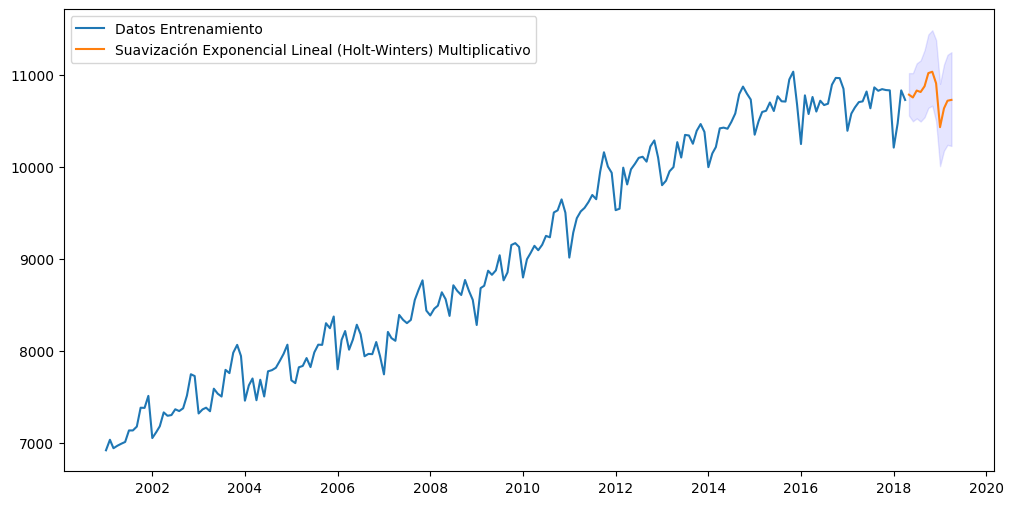

In [260]:
fig = plt.figure(figsize=(12, 6))
plt.plot(train_td,label="Datos Entrenamiento")
plt.plot(preds_hw_mul['Point_forecast'],label="Suavización Exponencial Lineal (Holt-Winters) Multiplicativo")
plt.fill_between(preds_hw_mul.index ,preds_hw_mul['lower_95'], preds_hw_mul['upper_95'], color='blue', alpha=0.1)
plt.legend(loc='upper left')
plt.show()

In [261]:
sel_hwintermul_alpha = ets_result.alpha,
sel_hwintermul_gamma  = ets_result.gamma
print(sel_hwintermul_alpha,sel_hwintermul_gamma)

(0.6067561515082243,) 3.9324384849177576e-05


In [262]:
rmse_hwinter_mul = np.sqrt(mean_squared_error(test_td,preds_hw_mul['Point_forecast']))
print(rmse_hwinter_mul)


122.36075024908216


In [263]:
print(f"En esta caso el α estimado es {sel_hwintermul_alpha}  el γ estimado es {sel_hwintermul_gamma}. Y el RMSE en la muestra de evaluación es {rmse_hwinter_mul}.")

En esta caso el α estimado es (0.6067561515082243,)  el γ estimado es 3.9324384849177576e-05. Y el RMSE en la muestra de evaluación es 122.36075024908216.


### **5 Resultados**

###rmse

In [264]:
rmse_data = {
    'Model': ['Simple Exponential Smoothing', 'Holt' ,'Holt-Winters (Additive)',  'Holt-Winters (Multiplicative)'],
    'RMSE': [ses_rmse,rmse_holt, rmse_hw_add, rmse_hwinter_mul]
}
rmse_df = pd.DataFrame(rmse_data)
rmse_df

,Model,RMSE
0,Simple Exponential Smoothing,186.786260
1,Holt,268.074929
2,Holt-Winters (Additive),210.809727
3,Holt-Winters (Multiplicative),122.360750


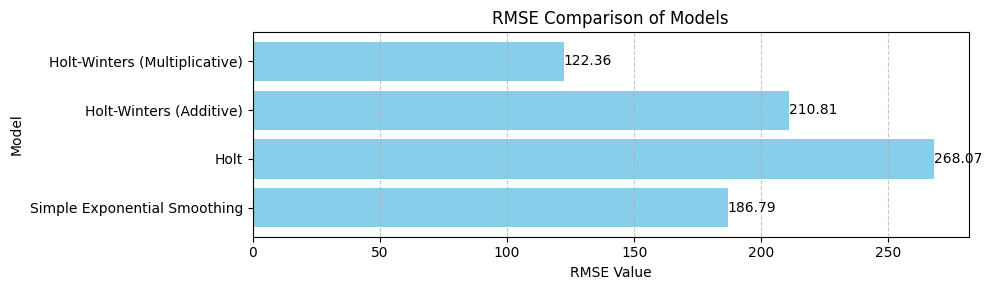

In [265]:
# Horizontal bar plot
plt.figure(figsize=(10, 3))
plt.barh(rmse_df['Model'], rmse_df['RMSE'], color='skyblue')
plt.xlabel('RMSE Value')
plt.ylabel('Model')
plt.title('RMSE Comparison of Models')
plt.grid(axis='x', linestyle='--', alpha=0.7)
# Annotate the bars with their RMSE values
for index, value in enumerate(rmse_df['RMSE']):
    plt.text(value, index, f'{value:.2f}', va='center')
plt.tight_layout()
plt.show()

###alpha - beta - gamma

In [266]:
print(ses_alpha)
print(sel_holt_alpha, sel_holt_beta)
print(sel_winter_alpha[0], sel_winter_beta[0], sel_winter_gamma)
print(ets_result.alpha,ets_result.gamma)

0.64828262016549
0.5619350383434504 5.619350383434504e-05
0.5210294726964335 5.210294726964335e-05 4.7897052730356654e-05
0.6067561515082243 3.9324384849177576e-05


In [267]:
metricas_data = {
    'Model': ['Simple Exponential Smoothing', 'Holt', 'Holt-Winters (Additive)', 'Holt-Winters (Multiplicative)'],
    'Alpha': [ses_alpha, sel_holt_alpha, sel_winter_alpha[0], ets_result.alpha],
    'Beta': [np.nan, sel_holt_beta, sel_winter_beta[0], np.nan],
    'Gamma': [np.nan, np.nan, sel_winter_gamma,ets_result.gamma]
}
metricas_df = pd.DataFrame(metricas_data)
metricas_df.sort_values(by='Alpha', inplace=True)
metricas_df

,Model,Alpha,Beta,Gamma
2,Holt-Winters (Additive),0.521029,0.000052,0.000048
1,Holt,0.561935,0.000056,NaN
3,Holt-Winters (Multiplicative),0.606756,NaN,0.000039
0,Simple Exponential Smoothing,0.648283,NaN,NaN


In [271]:
import altair as alt
import pandas as pd

# Convertir las columnas Beta y Gamma a tipo numérico para evitar errores en la escala
metricas_df['Beta'] = pd.to_numeric(metricas_df['Beta'])
metricas_df['Gamma'] = pd.to_numeric(metricas_df['Gamma'])

# Crear el gráfico comparativo con líneas horizontales
chart = alt.Chart(metricas_df).mark_rule().encode(
    y='Model',  # Variable en el eje Y
    x='Alpha',  # Variable en el eje X
    color='Model',  # Colorear las líneas por modelo
    tooltip=['Model', 'Alpha', 'Beta', 'Gamma'] # datos en el hover
).properties(
    title='Comparación de Métricas por Modelo'
)


# Ajustar la escala de Beta
beta_chart = alt.Chart(metricas_df).mark_rule().encode(
    y='Model',
    x='Beta',
    color='Model',
    tooltip=['Model', 'Alpha', 'Beta', 'Gamma'] # datos en el hover
).properties(
    title='Comparación de Beta por Modelo'
)

# Ajustar la escala de Gamma
gamma_chart = alt.Chart(metricas_df).mark_rule().encode(
    y='Model',
    x='Gamma',
    color='Model',
    tooltip=['Model', 'Alpha', 'Beta', 'Gamma'] # datos en el hover
).properties(
    title='Comparación de Gamma por Modelo'
)

# Combinar los gráficos en una sola visualización
(chart | beta_chart | gamma_chart)


alt.HConcatChart(...)

In [269]:
# Combinamos ambos dataframes para facilitar la comparación
combined_df = pd.merge(metricas_df, rmse_df, on='Model')

# Encontramos el modelo con el menor RMSE
best_model = combined_df.loc[combined_df['RMSE'].idxmin()]

# Imprimimos los resultados del mejor modelo
print(f"El mejor modelo es: {best_model['Model']}")
print("Con los siguientes parámetros y métricas:")
best_model


El mejor modelo es: Holt-Winters (Multiplicative)
Con los siguientes parámetros y métricas:


,2
Model,Holt-Winters (Multiplicative)
Alpha,0.606756
Beta,NaN
Gamma,0.000039
RMSE,122.36075


In [270]:
best_models = {}
# Iterate through each parameter
for col in ['Alpha', 'Beta', 'Gamma']:
    # Find the model with the highest value for the current parameter
    best_model = metricas_df.loc[metricas_df[col].idxmax(), 'Model']
    best_models[col] = best_model

best_models

{'Alpha': 'Simple Exponential Smoothing',
 'Beta': 'Holt',
 'Gamma': 'Holt-Winters (Additive)'}

El RMSE (Root Mean Squared Error) mide la diferencia entre los valores predichos por el modelo y los valores reales. Un RMSE bajo indica un buen ajuste del modelo a los datos, mientras que un RMSE alto indica un mal ajuste.
En este caso, el modelo con el RMSE más bajo es considerado el mejor
{Holt-Winters (Multiplicative)}

En este caso particular, el modelo  {Holt-Winters (Multiplicative)} predice los datos de una serie temporal con un error promedio menor respecto a otros modelos, por lo tanto es el más adecuado, lo que sugiere que este modelo ajusta mejor los datos que los otros modelos en este ejemplo

Si existiera un valor de RMSE igual en varios modelos, podria ser necesario revisar las metricas de Alpha, Beta y Gamma para determinar el mejor.

Además de comparar el RMSE, es importante analizar los parámetros (Alpha, Beta, Gamma)
de cada modelo para comprender cómo afectan al rendimiento.
*   **Alpha** controla el peso dado a las observaciones más recientes. Un valor de alpha más alto da más peso a las observaciones más recientes, y menor a las observaciones pasadas.
*   **Beta** controla el peso dado a la tendencia.
*   **Gamma** controla el peso dado a la estacionalidad.

Los mejores modelos segun las metricas Alpha, Beta y Gamma son:
* {'Alpha': 'Simple Exponential Smoothing',
 'Beta': 'Holt',
 'Gamma': 'Holt-Winters (Additive)'}